In [1]:
from random import choice, randint, random
from copy import deepcopy

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

num_classes = 10
input_shape = (28, 28, 1)
BATCH_SIZE = 128
EPOCHS = 15

(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map( normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2022-05-01 21:17:47.768875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 21:17:47.772876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-01 21:17:47.772888: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-01 21:17:47.773104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
def make_model(inner_layers):
    layer_list = []
    layer_list.append(tf.keras.Input(shape=input_shape))

    # Add other layers here
    layer_list.extend(inner_layers)

    # Add final layer and return
    layer_list.append(tf.keras.layers.Flatten())
    layer_list.append(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model = tf.keras.Sequential(layer_list)
    return model


def test_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    history = model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_test,
        verbose=0
    )

    accuracy = history.history["val_sparse_categorical_accuracy"][-1]
    return accuracy

In [ ]:
def generate_new_inner_layers(previous_inner_layers):
    previous_inner_layers_copy = deepcopy(previous_inner_layers)
    pertubation_possibilities = ["I"]*3  # Random insertion. 3x more likely than removal

    # Random removal
    if len(previous_inner_layers_copy) != 0:
        pertubation_possibilities.append('R')

    pertubation = choice(pertubation_possibilities)

    if pertubation == 'R':
        removal_index = randint(0, len(previous_inner_layers_copy)-1)
        del previous_inner_layers_copy[removal_index]
        return previous_inner_layers_copy

    elif pertubation == 'I':
        if len(previous_inner_layers_copy) > 2:
            insertion_index = randint(0, len(previous_inner_layers_copy))
        else:
            insertion_index = 0

        # Create random layer
        new_layer_char = choice(['C', 'M', 'D'])
        if new_layer_char == 'C':
            kernel_size = randint(2, 8)
            filters = randint(2, 60)
            new_layer = tf.keras.layers.Conv2D(filters, kernel_size=(kernel_size, kernel_size), activation="relu", padding="same")
        elif new_layer_char == 'M':
            pool_size = randint(2, 8)
            new_layer = tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size))
        elif new_layer_char == 'D':
            dropout_amount = random()
            new_layer = tf.keras.layers.Dropout(dropout_amount)

        previous_inner_layers_copy.insert(insertion_index, new_layer)

    return previous_inner_layers_copy


n_trials = 10
n_trials_avg = 5

results_list = []
for temperature in np.arange(0, 1, 0.1):
    print("New temperature:", temperature)
    avg_list = []
    last_accuracy = 0
    for _1 in range(n_trials_avg):
        print("New Trial")
        previous_inner_layers = []
        best_model = None
        best_accuracy = 0
        results_list_new = []
        for _2 in range(n_trials):
            new_inner_layers = generate_new_inner_layers(previous_inner_layers)

            try:
                model = make_model(new_inner_layers)
                accuracy = test_model(model)
                last_accuracy = accuracy
            except:
                results_list_new.append(last_accuracy)
                continue            

            random_val = random()
            if accuracy > best_accuracy or random_val < temperature:
                best_model = model
                best_accuracy = accuracy

                previous_inner_layers = new_inner_layers

                print(accuracy, new_inner_layers)

            results_list_new.append(best_accuracy)

        print(len(results_list_new))
        avg_list.append(results_list_new)

    avg_list = np.array(avg_list)
    avg_list = np.mean(avg_list, axis=0)

    results_list.append(avg_list)
    

In [6]:
results_list_np = np.array(results_list)

[0.0, 0.1, 0.2, 0.3, 0.4]


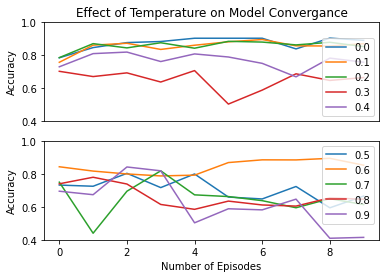

In [51]:
import matplotlib.pyplot as plt

print([x/10 for x in range(5)])
plt.subplot(2, 1, 1)
plt.title("Effect of Temperature on Model Convergance")
plt.ylabel("Accuracy")
plt.xticks([])
plt.ylim([0.4, 1])


for i in range(results_list_np.shape[0]):
    if i >= 5:
        plt.subplot(2, 1, 2)
        plt.plot(results_list[i])
    else:
        plt.plot(results_list[i])
        plt.legend([x/10 for x in range(5)])
    


plt.xlabel("Number of Episodes")
plt.ylabel("Accuracy")
plt.legend([x/10 for x in range(5, 10)])
plt.ylim([0.4, 1])
plt.show()


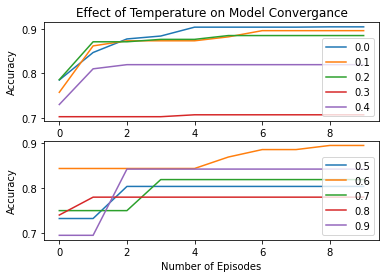

In [55]:
plt.subplot(2, 1, 1)
plt.title("Effect of Temperature on Model Convergance")
plt.ylabel("Accuracy")

for i in range(results_list_np.shape[0]):
    largest = 0
    new_list = []
    for val in results_list[i]:
        if val > largest:
            largest = val
        new_list.append(largest)
    if i >= 5:
        plt.subplot(2, 1, 2)
        plt.plot(new_list)
    else:
        plt.plot(new_list)
        plt.legend([x/10 for x in range(5)])


plt.xlabel("Number of Episodes")
plt.ylabel("Accuracy")
plt.legend([x/10 for x in range(5, 10)])
plt.show()

Text(0, 0.5, 'Accuracy')

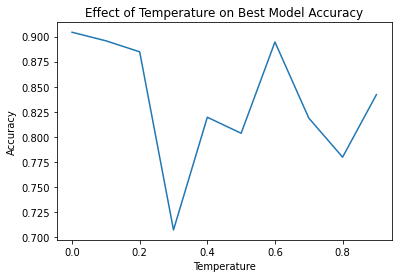

In [63]:
plt.plot([x/10 for x in range(10)], np.max(results_list_np, axis=1))
plt.title("Effect of Temperature on Best Model Accuracy")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")